The purpose of this notebook is to provide a visual comparison of two fits to the same data. 
**You need to provide the parameters; 
this notebook only compares existing fits, so it will not generate new ones.**

In [1]:
######################
##### Settings! ######
######################
#Here's the portion where you set stuff. Then just run everything and you're good!

params1 = [0.11928698, 4.30734747, 5.97003997, 3.16806475, 2.57927212] #First set of params goes here #Default to my fit with ng
params2 = [3.11532075e-01, 5.50963505e+02, 2.10977203e+00, 8.08819641e+00,0.00000000e+00] #And second goes here #Default to my fit no ng
params3 = [0.119,4.370,5.974,3.163,2.584] #And last here. #Default to Nick's fit (with ng)
labels=["With ng","f_ng = 0", "Nick's"]
title="Lindhard Model, SNorm"

In [2]:
#import R68_MCMC_MPI as mpi #importing runs the entire script... so I can't do that here. Instead I'll just have to copy code for now.

################################################################################
#Setup
################################################################################

#we may need some code in the ../python directory and/or matplotlib styles
import sys
import os
sys.path.append('../../python/')
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#set up matplotlib
os.environ['MPLCONFIGDIR'] = '../../mplstyles'
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])

import numpy as np
import pandas as pd
from constants import *
from scipy.optimize import minimize

#For some reason, this speeds things up!
os.environ["OMP_NUM_THREADS"] = "1"

#Added for notebook
import emcee

#For load data
import R68_load as r68
import R68_spec_tools as spec
#Import likelihood functions
from likelihoods import *
import R68_efficiencies as eff

In [3]:
################################################################################
#Fit Settings
################################################################################
#Construct a dictionary to store all the MCMC fit parameters and results
#These are all the settings a user will regularly change

        ########################## Data Settings ##########################
mcmc_data={'g4_load_frac':1,
          'cap_load_frac':1,
          #'cap_sim_file':'/data/chocula/villaa/cascadeSimData/si28_R68_400k.pkl',
          #'cap_rcapture':0.161,
          'cap_sim_file':'data/v3_400k.pkl',
          'cap_rcapture':0.218,
           ########################## Spectrum Settings ##########################
          'Emax': 2000, #[eVee]
          'Ebins': np.linspace(0,2500,251), #np.linspace(0,2000,201),
           'Efit_min':50, #[eVee]
           'Efit_max':2000, #1750, #[eVee]
           'spectrum_units':'reco-rate', #One of {'counts', 'reco-rate'}
           ########################## Yield Model Settings ##########################
           'Y_model':'Lind',
           'Y_labels': [r'k', r'$F_{NR}$'],
           'Y_bounds': [(0.05,0.3),(0,30)],
           #'Y_model':'Chav',
           #'Y_labels': [r'k', r'$a^{-1}$', r'$F_{NR}$'],
           #'Y_bounds': [(0.05,0.3),(0,2e3),(0,30)],
           #'Y_model':'Sor',
           #'Y_labels': [r'k', r'q', r'$F_{NR}$'],
           #'Y_bounds': [(0.05,0.3),(0,3e-2),(0,30)],
           #'Y_model':'Sor',
           #'Y_labels': [r'k', r'$\xi$', r'$F_{NR}$'],
           #'Y_bounds': [(0.05,0.3),(0,2e3),(0,30)],
           #'Y_model':'pchip',
           #'Y_labels': [r'k', 'Er0', 'Er1', 'Er2', 'f1', r'$F_{NR}$'],
           #'Y_bounds': [(0.05,0.3),(0,1e-3),(0,1e-3),(0,1e-3),(0,1),(0,10)],
           #'Y_model':'Shexp',
           #'Y_labels': [r'k', 'Yshelf', 'Ec', 'dE', 'alpha', r'$F_{NR}$'],
           #'Y_bounds': [(0.05,0.3),(0,0.3),(0,1e3),(0,1e3),(0,100),(0,30)],
           #'Y_model':'Pol3',
           #'Y_labels': [r'p0', r'p1', r'p2', r'$F_{NR}$'],
           #'Y_bounds': [(-0.5,0.5),(-5e-4,5e-4),(-5e-7,5e-7),(0,30)],
           ########################## Sim Spectra Settings ##########################
           'ER_spec_model':'sim', #One of {'sim', 'flat') to selct from G4 simulation or flat
           #'ER_par_labels':[r'$scale_{G4}$'],
           'ER_par_labels':[r'$scale_{ER}$'],
           'ER_par_bounds':[(0,20)], #Unitless scaling factor
           #'ER_spec_model':'flat',
           #'ER_par_labels':[r'$R0_{ER}$'],
           #'ER_par_bounds':[(0,4e-2)], # Units are [Counts/sec/eVee bin] or [Counts/eVee bin] depending on spectrum_units
           #
           'NR_spec_model':'sim', #One of {'sim', 'flat', 'exp') to selct from G4 simulation, flat, or exponential
           #'NR_par_labels':[r'$scale_{G4}$'],
           'NR_par_labels':[r'$scale_{NR}$'],
           'NR_par_bounds':[(0,20)], #Unitless scaling factor
           #'NR_spec_model':'exp',
           #'NR_par_labels':[r'$R0_{NR}$',r'$E0_{NR}$'], #R0*exp(-E/E0) gives NR spectrum (post-yield)
           #'NR_par_bounds':[(0,0.1),(0,2e3)], # Units are [Counts/sec/eVee bin, eVee] or [Counts/eVee bin] depending on spectrum_units
           #
           'NG_spec_model':'sim', #Not going to implement anything other than sim for (n,gamma) yet
           'NG_par_labels':[r'$scale_{ng}$'],
           'NG_par_bounds':[(0,10)], #Unitless scaling factor
           ########################## Likelihood Settings ##########################
           'likelihood':'SNorm', #One of {'Pois', 'Norm', 'SNorm'} Only SNorm uses sigmas, others assume Pois stats
           ########################## Uncertainty Settings ##########################
           'doDetRes': True, #Include detector resolution effects
           'fpeak':0.753, #0.753 -- 1.0
           'doEffsyst':True, #Include systematics from cut efficiencies
           'doBurstLeaksyst':True, #Include burst cut leakage systematic
           ########################## MCMC Settings ##########################
           'nwalkers':128,
           'nstep':500000,
           'guesses':'Uniform', #Can either be uniform or shape (nwalkers, ndim),
           'moves':'DE8020',#'Default': StretchMove, 'DE8020': 80/20 DEMove/DESnookerMove
           'saveMCMC':True
          }

In [4]:
################################################################################
#Parse Options
################################################################################
mcmc_data['labels']=mcmc_data['Y_labels']+mcmc_data['ER_par_labels']+mcmc_data['NR_par_labels']+mcmc_data['NG_par_labels']
mcmc_data['bounds']=mcmc_data['Y_bounds']+mcmc_data['ER_par_bounds']+mcmc_data['NR_par_bounds']+mcmc_data['NG_par_bounds']

#Special case if ER and NR are both sim and we want to use the same G4 scaling factor for both:
#if (mcmc_data['ER_spec_model']=='sim') and (mcmc_data['NR_spec_model']=='sim'):
if (mcmc_data['ER_par_labels']==[r'$scale_{G4}$']) and (mcmc_data['NR_par_labels']==[r'$scale_{G4}$']):
    mcmc_data['labels']=mcmc_data['Y_labels']+mcmc_data['NR_par_labels']+mcmc_data['NG_par_labels']
    mcmc_data['bounds']=mcmc_data['Y_bounds']+mcmc_data['NR_par_bounds']+mcmc_data['NG_par_bounds']
    
mcmc_data['ndim']=len(mcmc_data['labels'])

In [5]:
################################################################################
#Load Data
################################################################################

#Set eVee energy binning
Emax=mcmc_data['Emax']
Ebins=mcmc_data['Ebins']
Ebins_ctr=(Ebins[:-1]+Ebins[1:])/2

#Set fit range
E_lim_min=mcmc_data['Efit_min'] #eVee
E_lim_max=mcmc_data['Efit_max'] #eVee
spec_bounds=(np.digitize(E_lim_min,Ebins)-1,np.digitize(E_lim_max,Ebins)-1)
mcmc_data['spec_bounds']=spec_bounds

#Measured spectra background subtraction
meas=r68.load_measured(verbose=True)
tlive_PuBe=meas['PuBe']['tlive']

#Note that N_meas may be either in counts or reconstructed rate, depending on mcmc_data['spectrum_units']
#uncertainty is (high,low)
N_meas,dN_meas=spec.doBkgSub(meas, Ebins, mcmc_data['Efit_min'], mcmc_data['Efit_max'],\
                             doEffsyst=mcmc_data['doEffsyst'], doBurstLeaksyst=mcmc_data['doBurstLeaksyst'],\
                             output=mcmc_data['spectrum_units'])

if mcmc_data['likelihood']=='SNorm':
    #Precalculate split normal likelihood params if we're going to need it
    SNpars=getSNparsArray(N_meas[slice(*spec_bounds)],dN_meas[0][slice(*spec_bounds)],dN_meas[1][slice(*spec_bounds)])
    print("N_meas:",len(N_meas[slice(*spec_bounds)]))
    #print("N_pred:") #Doesn't exist yet.
    SNpars=SNpars.T
    print(len(N_meas[slice(*spec_bounds)]))
    print(len(SNpars[0]))

#Load g4 Simulations
#No need for this if we're using analytical models for both
if (mcmc_data['ER_spec_model']=='sim') or (mcmc_data['NR_spec_model']=='sim'):
    g4=r68.load_G4(load_frac=mcmc_data['g4_load_frac'])

    #Trim events that won't figure into the analysis range
    #Trimmed sim data
    if (mcmc_data['ER_spec_model']=='sim'):
        Eee_er=np.sum(g4['ER']['E'],axis=1)
        Evec_er_cut=(Eee_er>10) & (Eee_er<3e3)
        Evec_er=g4['ER']['E'][Evec_er_cut]

    if (mcmc_data['NR_spec_model']=='sim'):
        Eee_nr=np.sum(g4['NR']['E'],axis=1)
        Evec_nr_cut=(Eee_nr>10) & (Eee_nr<30e3)
        Evec_nr=g4['NR']['E'][Evec_nr_cut]


#Load Capture Simulations
cap=r68.load_simcap(file=mcmc_data['cap_sim_file'], rcapture=mcmc_data['cap_rcapture'], load_frac=mcmc_data['cap_load_frac'])

#Pre-calculate Simulated ER spectrum
#This is independent of other params, so we can do this once and reuse it
if mcmc_data['ER_spec_model']=='sim':
    if mcmc_data['spectrum_units']=='counts':
        N_er = spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_er, Yield=1.0, F=F, scale=1,\
                                           doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'],\
                                           doEffs=True)    
    elif mcmc_data['spectrum_units']=='reco-rate':
        N_er = spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_er, Yield=1.0, F=F, scale=1,\
                                           doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'],\
                                           doEffs=False)
elif mcmc_data['ER_spec_model']=='flat':
    N_er = np.ones_like(Ebins_ctr)
else:
    print('ER_spec_model: ',mcmc_data['ER_spec_model'],' not implemented yet.')
        
#Import yield models
import R68_yield as Yield
#Initialize Yield model
Y=Yield.Yield('Lind',[0.15])
model=mcmc_data['Y_model']
Y=Yield.Yield(model,np.zeros(Y.model_npar[model]))

Loading Measured Data...
PuBe events:  (476731,)
Bkg events:  (174636,)


/Users/villaa/R68_paper2019/analysis_notebooks/Fit_Comparisons/../../python/R68_spec_tools.py:55: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 +\
/Users/villaa/R68_paper2019/analysis_notebooks/Fit_Comparisons/../../python/R68_spec_tools.py:60: RuntimeWarning: divide by zero encountered in true_divide
  R_meas_Bkg = N_meas_Bkg/TE_Bkg
/Users/villaa/R68_paper2019/analysis_notebooks/Fit_Comparisons/../../python/R68_spec_tools.py:62: RuntimeWarning: invalid value encountered in true_divide
  dR_meas_PuBe_hi = R_meas_PuBe*np.sqrt( (dN_meas_PuBe_Pois/N_meas_PuBe)**2 +\
/Users/villaa/R68_paper2019/analysis_notebooks/Fit_Comparisons/../../python/R68_spec_tools.py:64: RuntimeWarning: invalid value encountered in true_divide
  dR_meas_PuBe_low = R_meas_PuBe*np.sqrt( (dN_meas_PuBe_Pois/N_meas_PuBe)**2 +\
/Users/villaa/R68_paper2019/analysis_notebooks/Fit_Comparisons/../../python/R68_spec_tools.py:65: RuntimeWarning: div

N_meas: 195
195
195
Loading Geant4 Data...
(528848, 7)
(129555, 7)
Loading NRs...
0.1  min
Loading ERs...
0.0  min
Loading (n,gamma) Data...
382155
dict_keys(['xx', 'yy', 'ex', 'ey'])


In [6]:
#Lazy solution: Just. Copy the entire function. 
#Now all the calculations are here instead of me having to rewrite them.

################################################################################
#Calculate Log probability, log(likelihood*prior)
################################################################################
#theta: array of fit parameters (yield_par0, yield_par1, ...,  F_NR, scale_g4, scale_ng, ...)
#    These are in the same order as mcmc_data['labels']
#theta_bounds: paramter bounds, shape should be len(theta)x2
#spec_bounds: range of bin numbers in spectrum to consider. The analysis range is [bin_low,bin_high)
#likelihood: Likelihood function, either 'Pois' or 'Norm'

N_pred = None #Setting this up so I can make it global to call it in a moment.

def calc_log_likelihood(theta=[0.2,1,1,1,1,1], theta_bounds=tuple(mcmc_data['bounds']), spec_bounds=mcmc_data['spec_bounds'],
                  likelihood=mcmc_data['likelihood'],verbose=False):
    
    #Access the global data
    #These must be already defined!!!
    global mcmc_data, eff, N_meas, N_er, tlive_PuBe, Evec_nr, cap, Y, N_pred
    
    ############
    #Parse fit params
    nYpar=Y.npars

    Y.set_pars(theta[:nYpar])
    F_NR=theta[nYpar] #theta[2] 
    if verbose:
        print(Y.pars,F_NR)
    #so the first 3 should definitely be used - why are they acting like they have no effect?
    # I must be misunderstanding what this does; these are the only ones that *don't* work.
    
    #Special check for pchip yield
    #Will fail to solve if the parameters are not ordered.
    #This effectively includes some parameter ordering in their priors
    if not Y.solve():
        return -np.inf
        
    #Grab correct ER scaling factor from theta
    if mcmc_data['ER_spec_model']=='sim':
        if '$scale_{G4}$' in mcmc_data['labels']:
            scale_er=theta[mcmc_data['labels'].index('$scale_{G4}$')]/g4['ER']['tlive']
        else:
            scale_er=theta[mcmc_data['labels'].index('$scale_{ER}$')]/g4['ER']['tlive']
    elif mcmc_data['ER_spec_model']=='flat':
        scale_er=theta[mcmc_data['labels'].index(r'$R0_{ER}$')]
        
    ##########
    #Build the spectra
    if mcmc_data['spectrum_units']=='counts':
        #This includes detector resolution, triggering, and cut efficiency effects
        #Does NOT include livetime or write efficiency

        #NR
        if mcmc_data['NR_spec_model']=='sim':
            N_nr=spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_nr, Yield=Y, F=F_NR, scale=1,\
                                             doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'],\
                                             doEffs=True)
            if '$scale_{G4}$' in mcmc_data['labels']:
                scale_nr=theta[mcmc_data['labels'].index('$scale_{G4}$')]/g4['NR']['tlive']
            else:
                scale_nr=theta[mcmc_data['labels'].index('$scale_{NR}$')]/g4['NR']['tlive']
        elif mcmc_data['NR_spec_model']=='exp':
            N_nr=np.exp(-Ebins_ctr/theta[mcmc_data['labels'].index(r'$E0_{NR}$')])
            scale_nr=theta[mcmc_data['labels'].index(r'$R0_{NR}$')]
            
        #(n,gamma)
        if verbose:
            print('spec_units == counts')
        N_ng=spec.buildAvgSimSpectrum_ee_composite(Ebins=Ebins, Evec=cap['E'], dEvec=cap['dE'],\
                                                   Yield=Y, F=F_NR, scale=1, doDetRes=mcmc_data['doDetRes'],\
                                                   fpeak=mcmc_data['fpeak'], doEffs=True,verbose=verbose)
        scale_ng=theta[mcmc_data['labels'].index('$scale_{ng}$')]/cap['tlive']

        #Adjust for livetime and write efficiency
        N_pred = (N_nr*scale_nr +
                  N_er*scale_er + 
                  N_ng*scale_ng)*tlive_PuBe*eff.eff_write
        #print(N_pred[0])
    
    elif mcmc_data['spectrum_units']=='reco-rate':
        #Don't apply any efficiency effects to simulated spectrum
        #NR
        if mcmc_data['NR_spec_model']=='sim':
            N_nr=spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_nr, Yield=Y, F=F_NR, scale=1,\
                                             doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'],\
                                             doEffs=False)
            #print(Y) #It's getting here, but printing Y doesn't tell me anything about it.
            if '$scale_{G4}$' in mcmc_data['labels']:
                scale_nr=theta[mcmc_data['labels'].index('$scale_{G4}$')]/g4['NR']['tlive']
            else:
                scale_nr=theta[mcmc_data['labels'].index('$scale_{NR}$')]/g4['NR']['tlive']
        elif mcmc_data['NR_spec_model']=='exp':
            N_nr=np.exp(-Ebins_ctr/theta[mcmc_data['labels'].index(r'$E0_{NR}$')])
            scale_nr=theta[mcmc_data['labels'].index(r'$R0_{NR}$')]
        
        if verbose:
            print('spec_units == reco-rate')
        #(n,gamma)
        N_ng=spec.buildAvgSimSpectrum_ee_composite(Ebins=Ebins, Evec=cap['E'], dEvec=cap['dE'],\
                                                   Yield=Y, F=F_NR, scale=1, doDetRes=mcmc_data['doDetRes'],\
                                                   fpeak=mcmc_data['fpeak'], doEffs=False,verbose=verbose)
        scale_ng=theta[mcmc_data['labels'].index('$scale_{ng}$')]/cap['tlive']
        
        #Calculate rate (though we'll still call them N_* just to be confusing)
        # This is where N_pred is first defined. By here, N_meas[()] has shrunk to 96.
        # So, I need to redo the SNpars, as N_pred is never changed.
        N_pred = (N_nr*scale_nr + 
                  N_er*scale_er + 
                  N_ng*scale_ng)
        if verbose:
            print("N_ng:",N_ng[0:3]) 
            print("N_nr:", N_nr[0:3])
            print("F_NR:", F_NR)
            #print(N_pred[0])

    ##########
    #Calculate the log probability = log prior + log likelihood
    ll=None
    
    if likelihood=='Norm':
        ll = ll_norm(N_meas[slice(*spec_bounds)],N_pred[slice(*spec_bounds)])
    elif likelihood=='Pois':
        ll = ll_pois(N_meas[slice(*spec_bounds)],N_pred[slice(*spec_bounds)])
    elif likelihood=='SNorm':
        #Precalculate split normal likelihood params if we're going to need it
        SNpars=getSNparsArray(N_meas[slice(*spec_bounds)],dN_meas[0][slice(*spec_bounds)],dN_meas[1][slice(*spec_bounds)])
        #print("N_pred:") #Doesn't exist yet.
        SNpars=SNpars.T
        # Here, N_pred[()] and N_meas[slice()] are both 96. However, SNpars already len 195.
        ll = ll_SNorm(N_pred[slice(*spec_bounds)],*SNpars) #4 parameters
        #print(spec_bounds) #Slice from (5,101) - function parameter.
        #print(SNpars[0][0]) #Static, as expected.
    else:
        print('Error: Bad likelihood')
        return None
    
    if not np.isfinite(ll):
        return -np.inf
    
    return ll #When optimizing, I only want to optimize the log likelihood, not of prior*likelihood.
    #So I've slightly altered this function.
    
    #ll depends on N_pred, which depends on N_nr, which depends depends on F_NR, which is theta[2].
    #I have confirmed that the function called when defining N_nr is actually using the variable `F`
    #Which F_NR is assigned to. So F_NR **should** affect the output.
    #So the returned value should depend on the first three entries of theta, but DEFINITELY on the third.
    #why won't it adjust them then?

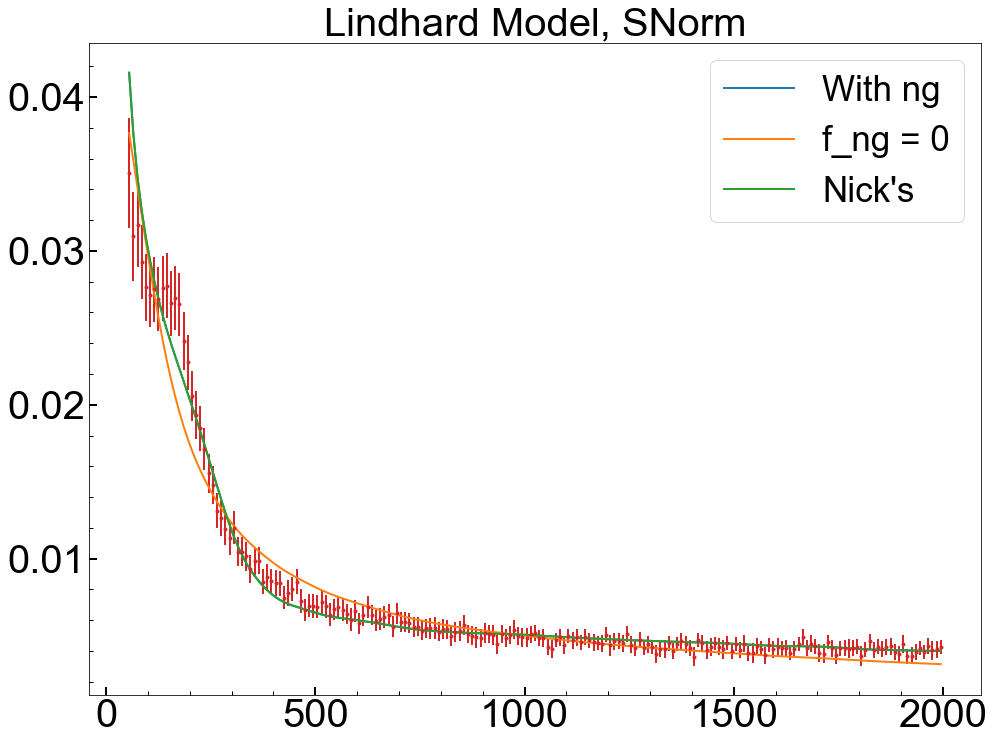

In [7]:
calc_log_likelihood(params1)
plt.plot(Ebins_ctr[slice(*spec_bounds)],N_pred[slice(*spec_bounds)],label=labels[0])
calc_log_likelihood(params2)
plt.plot(Ebins_ctr[slice(*spec_bounds)],N_pred[slice(*spec_bounds)],label=labels[1])
calc_log_likelihood(params3)
plt.plot(Ebins_ctr[slice(*spec_bounds)],N_pred[slice(*spec_bounds)],label=labels[2])
plt.errorbar(Ebins_ctr[slice(*spec_bounds)],N_meas[slice(*spec_bounds)],yerr=0.5*(dN_meas[0]+dN_meas[1])[slice(*spec_bounds)],fmt='.')

plt.title(title,fontsize=40)
plt.legend()

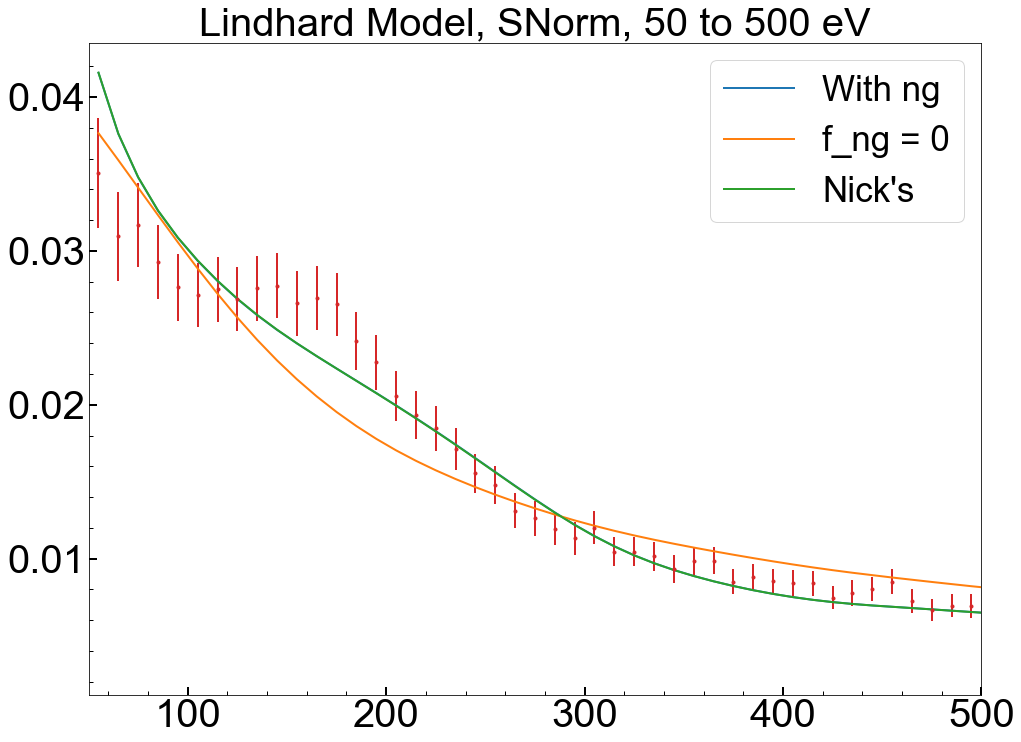

In [8]:
calc_log_likelihood(params1)
plt.plot(Ebins_ctr[slice(*spec_bounds)],N_pred[slice(*spec_bounds)],label=labels[0])
calc_log_likelihood(params2)
plt.plot(Ebins_ctr[slice(*spec_bounds)],N_pred[slice(*spec_bounds)],label=labels[1])
calc_log_likelihood(params3)
plt.plot(Ebins_ctr[slice(*spec_bounds)],N_pred[slice(*spec_bounds)],label=labels[2])
plt.errorbar(Ebins_ctr[slice(*spec_bounds)],N_meas[slice(*spec_bounds)],yerr=0.5*(dN_meas[0]+dN_meas[1])[slice(*spec_bounds)],fmt='.')
plt.xlim(50,500)

plt.title(title+", 50 to 500 eV",fontsize=40)
plt.legend()

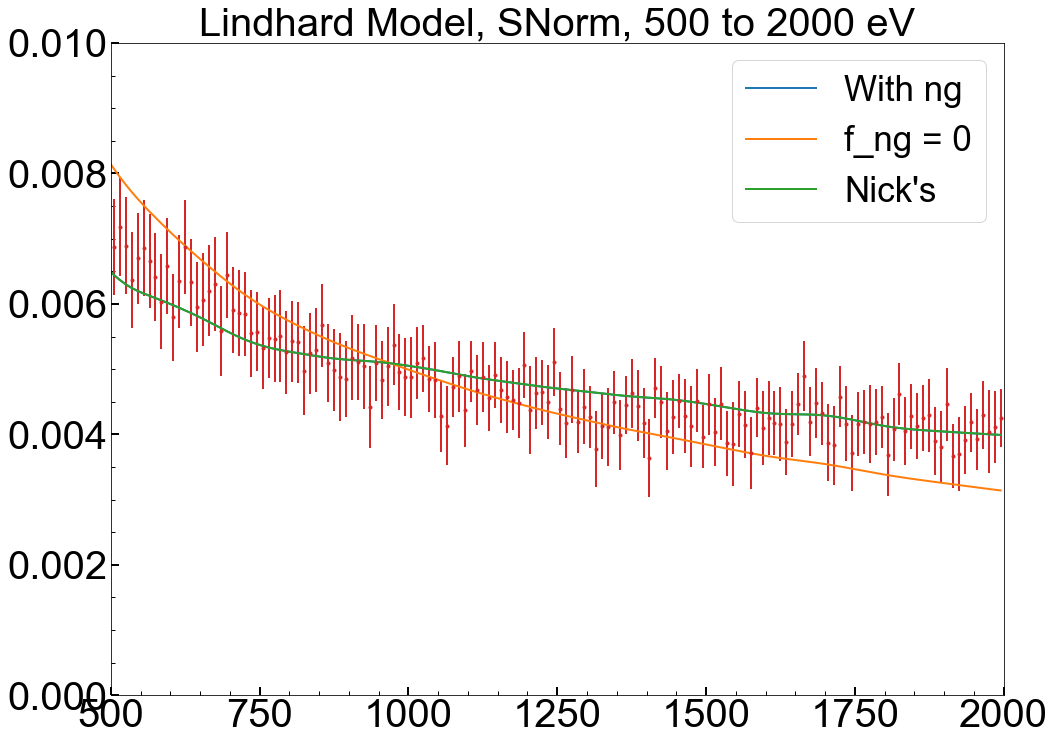

In [9]:
calc_log_likelihood(params1)
plt.plot(Ebins_ctr[slice(*spec_bounds)],N_pred[slice(*spec_bounds)],label=labels[0])
calc_log_likelihood(params2)
plt.plot(Ebins_ctr[slice(*spec_bounds)],N_pred[slice(*spec_bounds)],label=labels[1])
calc_log_likelihood(params3)
plt.plot(Ebins_ctr[slice(*spec_bounds)],N_pred[slice(*spec_bounds)],label=labels[2])
plt.errorbar(Ebins_ctr[slice(*spec_bounds)],N_meas[slice(*spec_bounds)],yerr=0.5*(dN_meas[0]+dN_meas[1])[slice(*spec_bounds)],fmt='.')

plt.xlim(500,2000)
plt.ylim(0,0.01)

plt.title(title+", 500 to 2000 eV",fontsize=40)
plt.legend()